In [3]:
import glob
from matplotlib import image 
from matplotlib import pyplot as plt
from PIL import Image
import os
import cv2 as cv
import numpy as np
import scipy.io
import random
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score
import math

1.Downloading the data and Undersatnding it

In [4]:
!wget -q {"http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"}
!tar -xzf /content/BSR_bsds500.tgz


In [5]:
# Creating the output directory
!mkdir '/content/output'
!mkdir '/content/output/Ground-Truth'
!mkdir '/content/output/Result'


In [6]:
#saving output
directory = "content"
    
# Parent Directory path
parent_dir = "."

# Path
path = os.path.join(parent_dir, directory) 
if(not os.path.exists(path)):
    os.mkdir(path)

## Create 'output' directory to save all outputs inside
directory = "output"
    
# Parent Directory path
parent_dir = "./content"
    
# Path
path = os.path.join(parent_dir, directory) 
if(not os.path.exists(path)):
    os.mkdir(path)

## Create 'Ground Truth' directory
directory = "Ground-Truth"
    
# Parent Directory path
parent_dir = "./content/output"
    
# Path
path = os.path.join(parent_dir, directory) 
if(not os.path.exists(path)):
    os.mkdir(path)

## Create 'Ground Truth' directory
directory = "Result"
    
# Parent Directory path
parent_dir = "./content/output"
    
# Path
path = os.path.join(parent_dir, directory) 
if(not os.path.exists(path)):
    os.mkdir(path)    

In [7]:
#Get the images for training
training_images = sorted(glob.glob("BSR/BSDS500/data/images/train/**/*.jpg", recursive=True))

#Get the images for testing
testing_images = sorted(glob.glob("BSR/BSDS500/data/images/test/**/*.jpg", recursive=True))
testing_images = testing_images[0:50]

#Get the ground-truth for training
ground_truth_training = sorted(glob.glob("BSR/BSDS500/data/groundTruth/train/**/*.mat", recursive=True))

#Get the ground-truth for testing
ground_truth_testing = sorted(glob.glob("BSR/BSDS500/data/groundTruth/test/**/*.mat", recursive=True))
ground_truth_testing = ground_truth_testing[0:50]

In [8]:
# Loading images
testing_data = []
for path in testing_images:
    img = image.imread(path)
    testing_data.append(img)

In [9]:
testing_data[0].shape

(321, 481, 3)

2.Visualize the image and the ground truth segmentation


In [10]:
def ground_truth_images_func(index,dataset):
  ground_truth_image = scipy.io.loadmat(dataset[index])
  ground_truth_image = np.squeeze(ground_truth_image['groundTruth'])
 # print(ground_truth_image)
  #print(ground_truth_image.shape)
  # print(len(ground_truth_image))
  
  ground_truth_images = [] #making a list for the ground truth images 
  number_of_ground_truths = len(ground_truth_image)
  for i in range(number_of_ground_truths):
    current_ground_truth = ground_truth_image[i][0][0][0]
    ground_truth_images.append(current_ground_truth)
  return ground_truth_images


In [11]:
def read_image(index, dataset):
  path='./content/output/Ground-Truth'  #output is saved here
  file_name = str(dataset).lower() + ' ' + str(index) + ' visualization' #file name
  fig, axarr = plt.subplots(2,3, figsize = (8, 8))

  if dataset == "TRAIN":
    normal_dataset = training_images
    ground_truth_dataset = ground_truth_training
  if dataset == "TEST":
    normal_dataset = testing_images
    ground_truth_dataset = ground_truth_testing
  #if dataset == "predection_images":  

  #creating an empty list of images
  images = []  
  normal_image = image.imread(normal_dataset[index])
  images.append(normal_image)
  ground_truth_images = ground_truth_images_func(index,  ground_truth_dataset) # Getting the ground truth of the image
  images = images + ground_truth_images  # to display all
  #looping through the images list to show the image
  for i in range(len(images)):
    row = i // 3
    col = i % 3
    if i == 0:
      axarr[row][col].imshow(images[0])
    axarr[i // 3][i % 3].imshow(images[i], interpolation='nearest')
  fig.suptitle(file_name, fontsize=16)
  plt.savefig(os.path.join(path, file_name), bbox_inches = 'tight')
  plt.show()


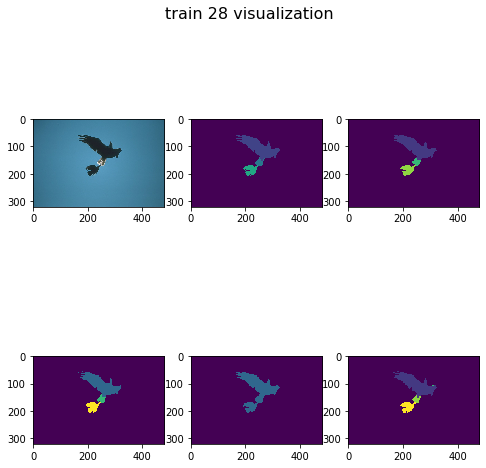

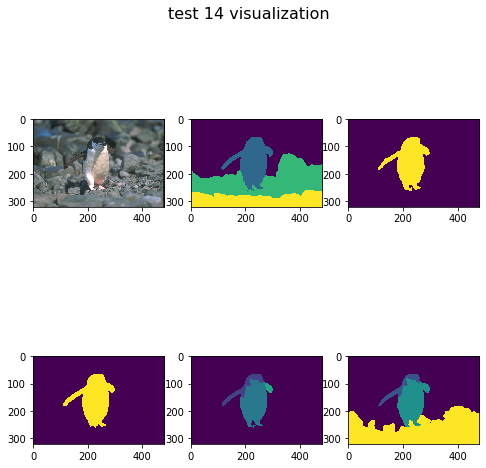

In [12]:

datasets = ["TRAIN", "TEST"]
random_images = random.sample(range(0, 50), 2) # Calling the above function to get 2 random images to visualize

# Visualize a sample from training dataset and a sample from test data set alternatively
for i in range(len(random_images)):
    read_image(random_images[i], datasets[i & 1])

In [13]:
'''# For the comparison part
f = []
for i in range(len(random_images)):
  f.append(ground_truth_images_func(random_images[i], datasets[i & 1]))'''

'# For the comparison part\nf = []\nfor i in range(len(random_images)):\n  f.append(ground_truth_images_func(random_images[i], datasets[i & 1]))'

In [14]:
'''from google.colab import files
!zip -qq -r /content/output.zip /content/output
files.download("/content/output.zip")'''

'from google.colab import files\n!zip -qq -r /content/output.zip /content/output\nfiles.download("/content/output.zip")'

K-means implementation

In [15]:
K_range= [3,5,7,9,11]


In [16]:
def plot_img_seg(img, seg, k):
    figure_size = 15
    plt.figure(figsize=(figure_size,figure_size))
    plt.subplot(1,2,1),plt.imshow(img)
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(1,2,2),plt.imshow(seg)
    plt.title('Segmented Image when K = %i' % k), plt.xticks([]), plt.yticks([])
    plt.show()

In [17]:
def kmean_f(img, k):
    feature = img.reshape((-1, 3))
    km = KMeans(n_clusters=k)
    km.fit(feature)
    seg = km.predict(feature)
    seg = seg.reshape((img[:, :, 0].shape))
    return seg

In [18]:
print(testing_data[0].shape)

(321, 481, 3)


In [19]:
path='./content/output/Result'
ind_name = 0
pred_img = []
for test_img in testing_data:
    image_list = []
    fig, axarr = plt.subplots(2,3, figsize = (15, 15))
    file_name = 'img_' + str(ind_name)
    image_list.append(test_img)
    for k in K_range:
        image_list.append(kmean_f(test_img, k))
    pred_img.append(image_list[1:])
    for i in range(len(image_list)):
        row = i // 3
        col = i % 3
        if i == 0:
            axarr[row][col].imshow(image_list[0])
        axarr[i // 3][i % 3].imshow(image_list[i], interpolation='nearest')
    
    fig.suptitle(file_name, fontsize=16)
    plt.savefig(os.path.join(path, file_name), bbox_inches = 'tight')
    plt.close(fig)
    ind_name += 1 

F-measure and Conditional Entropy



In [20]:
def sizeOfIntersection(cluster, truth):
  size=0
  n=len(cluster)
  for i in range(n):
    if(cluster[i] in truth):
      size+=1
  return size
'''def conditional_entropy(clusters, truths, numElements):
  k=len(clusters)
  r=len(truths)
  #Conditional Entropy of T with respect to Ci
  H_i = np.zeros(k)
  for i in range(k):
    for j in range(r):
      nij=sizeOfIntersection(clusters[i], truths[j])
      ni=len(clusters[i])
      if(nij>0):
        H_i[i] -= (nij/ni)*math.log((nij/ni),2)
  i=0      
  for i in range(k):
    ni=len(clusters[i])
    H_i[i] = (ni/numElements) * H_i[i]
  H=np.sum(H_i)
  return H'''

'def conditional_entropy(clusters, truths, numElements):\n  k=len(clusters)\n  r=len(truths)\n  #Conditional Entropy of T with respect to Ci\n  H_i = np.zeros(k)\n  for i in range(k):\n    for j in range(r):\n      nij=sizeOfIntersection(clusters[i], truths[j])\n      ni=len(clusters[i])\n      if(nij>0):\n        H_i[i] -= (nij/ni)*math.log((nij/ni),2)\n  i=0      \n  for i in range(k):\n    ni=len(clusters[i])\n    H_i[i] = (ni/numElements) * H_i[i]\n  H=np.sum(H_i)\n  return H'

In [21]:
def Purity(clusters, truths, numElements):
  #Total Purity
  purity=0 

  #Name each cluster
  k=len(clusters)
  results = np.zeros((k,2), dtype=object)

  for i in range(k):
    max= -1
    for j in range(len(truths)):
      temp=sizeOfIntersection(clusters[i], truths[j])
      if(temp>max):
        max=temp
        max_T=j
    results[i][0]=max_T #index of best matching class
    results[i][1]=max   #number elements matched from best matching class

  #Calculate Purity
  purity_i = np.zeros(k)
  for i in range(k):
    purity_i[i]=results[i][1]/len(clusters[i])
    purity+=purity_i[i]*len(clusters[i])/numElements
  return results,purity_i, purity
def FMeasure(clusters, truths, numElements):
  results,prec, purity = Purity(clusters, truths, numElements)
  F=0
  k=len(clusters)

  #Calculate Recall
  rec=np.zeros(k)
  for i in range(k):
    j=results[i][0]
    rec[i]=results[i][1]/(len(truths[j]))

  #Calculate F  
  for i in range(k):
    temp=(2*prec[i]*rec[i])/(prec[i]+rec[i])
    F+=temp
  F/=k
  return F  

In [22]:

path = ground_truth_testing[0]


In [23]:
pred_img[0][0]

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [2, 2, 2, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]], dtype=int32)

In [24]:
from sklearn.metrics import f1_score

In [25]:
def conditional_entropy(seg, gt):
    """
    seg : segmented image
    gt : ground truth image 
    """
    clusters = np.unique(seg).tolist()
    gt_clusters = np.unique(gt)
    H = 0
    # for every cluster in seg
    for cluster in clusters:
        Hi = 0
        indices = np.where(seg == cluster)
        partitions = gt[indices]
        # for every cluster in gt
        for gt_cluster in gt_clusters:
            nij = partitions[partitions == gt_cluster].shape[0]
            ni =  indices[0].shape[0]
            if nij / ni != 0:
                Hi += (nij / ni) * np.log2(nij / ni)
        Hi *= -1

        H += len(indices)*Hi/len(seg)
    return H

In [33]:
def evaluate(predection_images,ground_truth_testing, krange):
    gt=[]
    good_img_pf = []
    bad_img_pf = []
    good_img_pc = []
    bad_img_pc = []
    good_img_gtf = []
    bad_img_gtf = []
    good_img_gtc = []
    bad_img_gtc = []
    min_f = 1
    max_f = 0
    min_c = 200
    max_c = 0
    for i in range(50): 
         ground_truth_images= ground_truth_images_func(i,ground_truth_testing)
         gt.append(ground_truth_images)
    F_sum = [] 
    C_sum = []
   
    F_dataset=0
    C_dataset=0
    for i in range(50):
      fsum_list = []
      csum_list = []
      fsum = 0
      csum = 0
      l = len(gt[i])
      if l>5:
        l=5
      for j in range(l):
     #   print("bla")
        pred = predection_images[i][j]
        gtx = gt[i][j]
        x=pred.shape[0]
        y=pred.shape[1]
       
        F = f1_score(gtx.reshape((-1, 1)), pred.reshape((-1, 1)), average='weighted', zero_division=1)
        #print("another bla")
        if F<min_f:
          min_f=F
          bad_f= i
         # print("bad_f", bad_f)          #index of bad f measure
          bad_img_pf = pred
          bad_img_gtf = gtx
        if F>max_f:
          max_f=F  
          good_f=i 
         # print("good_f", good_f)  #index of good f measure
          good_img_pf =pred
          good_img_gtf = gtx
        fsum += F
        F_dataset += F
        C = conditional_entropy(pred, gtx)
        if C<min_c:
          min_c=C
          bad_c= i   
       #   print("bad_c", bad_c)      #index of bad conditional entropy
          bad_img_pc = pred
          bad_img_gtc = gtx
        if C>max_c:
          max_c=C  
          good_c= i
         # print("good_c", good_c)        #index of good conditional entropy
          good_img_pc = pred
          good_img_gtc = gtx
        csum += C
        C_dataset += C
        print(f'For K={krange[j]} Ground Truth = {i+1}: F-Measure = {F}, Conditional Entropy = {C}')
      fsum_value = fsum / l
      csum_value = csum / l
      fsum_list.append(fsum_value)
      csum_list.append(csum_value)
      print(f'For Ground Truth = {i+1}:Average F-Measure = {fsum_value}\n Average Conditional Entropy = {csum_value} \n')
      F_sum.append(fsum_list)
      C_sum.append(csum_list)
    F_dataset = F_dataset/250
    C_dataset = C_dataset/250
    print(f'Average F-Measure for the dataset= {F_dataset},Average Conditional Entropy for the dataset= {C_dataset} \n')
    print("Good Conditional Entropy")
   # print(good_img_pc.shape)
  #  print(good_img_gtc.shape)
    plot_img_seg(good_img_pc,good_img_gtc,good_c)
    print("Bad Conditional Entropy")
  #  print(bad_img_pc.shape)
   # print(bad_img_gtc.shape)
    plot_img_seg(bad_img_pc,bad_img_gtc,bad_c)
    print("Good F-measure")
 #   print(good_img_pf.shape)
  #  print(good_img_gtf.shape)
    plot_img_seg(good_img_pf,good_img_gtf,good_f)
    print("Bad F-measure")
 #   print(bad_img_pf.shape)
 #   print(bad_img_gtf.shape)
    plot_img_seg(bad_img_pf,bad_img_gtf,bad_f)
#     print("Bad F-measure")
#     read_image(bad_f, "TEST")
#     print("Good F-measure")
#     read_image(good_f, "TEST")
#     print("Bad Conditional Entropy")
#     read_image(bad_c, "TEST")
#     print("Good Conditional Entropy")
#     read_image(good_c, "TEST")
    return F_sum, C_sum

In [34]:

#evaluate(pred_img, ground_truth_testing)

bad_f 0
good_f 0
bad_c 0
good_c 0
For K=3 Ground Truth = 1: F-Measure = 0.517057275497789, Conditional Entropy = 0.022875088427781652
bad_f 0
good_c 0
For K=5 Ground Truth = 1: F-Measure = 0.3880826746523342, Conditional Entropy = 0.035557036939898444
bad_f 0
good_c 0
For K=7 Ground Truth = 1: F-Measure = 0.06028053786737616, Conditional Entropy = 0.05844337719230374
good_c 0
For K=9 Ground Truth = 1: F-Measure = 0.42923217368653266, Conditional Entropy = 0.06125876253389333
bad_f 0
good_c 0
For K=11 Ground Truth = 1: F-Measure = 0.015960481202309636, Conditional Entropy = 0.08131271398985679
For Ground Truth = 1:Average F-Measure = 0.2821226285812683
 Average Conditional Entropy = 0.051889395816746786 

bad_f 1
For K=3 Ground Truth = 2: F-Measure = 0.0004654548743166806, Conditional Entropy = 0.03289384313715307
bad_f 1
good_c 1
For K=5 Ground Truth = 2: F-Measure = 0.0004644485590313918, Conditional Entropy = 0.09031904004832662
For K=7 Ground Truth = 2: F-Measure = 0.077641475841982

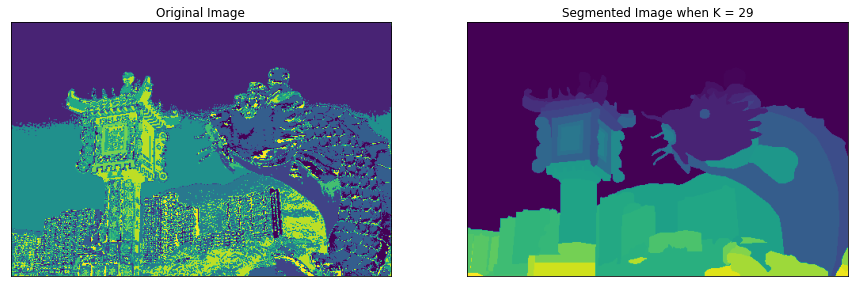

Bad Conditional Entropy
(481, 321)
(481, 321)


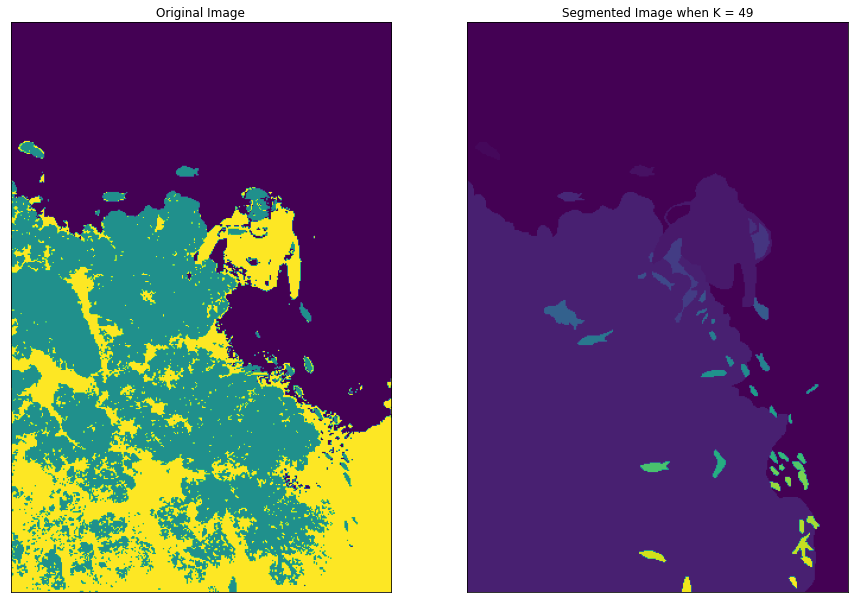

Good F-measure
(321, 481)
(321, 481)


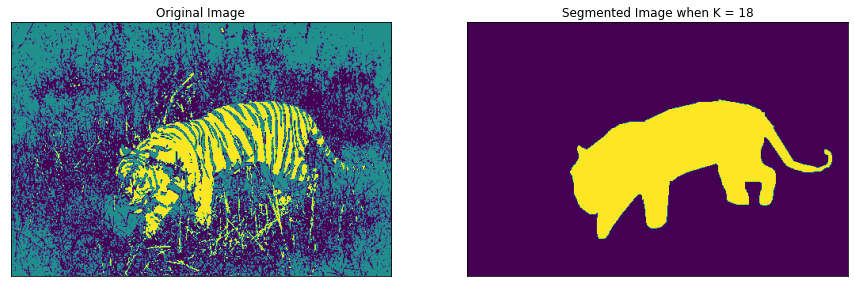

Bad F-measure
(481, 321)
(481, 321)


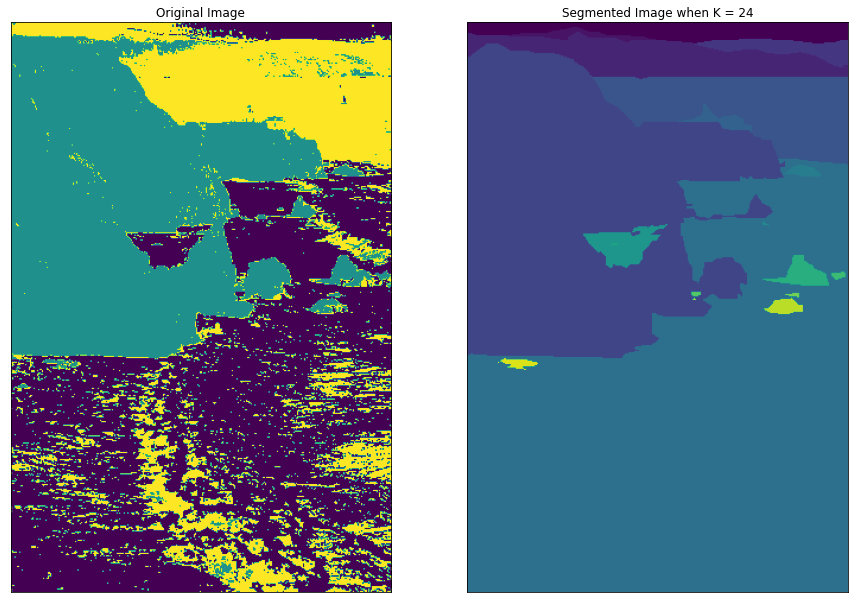

In [35]:

F,C = evaluate(pred_img,ground_truth_testing,K_range) 
      

4.Big picture

In [ ]:
for j in range(5):
    fig, axarr = plt.subplots(2,3, figsize = (20, 20))
    file_name = 'img_' + str(j)
    for i in range(6):
        row = i // 3
        col = i % 3
        if i == 0:
            axarr[row][col].imshow(testing_data[j])
        else:
            axarr[row][col].imshow(pred_img[j][i-1], interpolation='nearest')
        fig.suptitle(file_name, fontsize=16)
    plt.show()